<a href="https://colab.research.google.com/github/SNOOthiking/SHOPPING/blob/snoo/dacon_winner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google colab 드라이브 연결

In [3]:
from google.colab import drive
from os.path import join

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 모듈 임포트

In [4]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
import gc 
from tqdm import tqdm, tqdm_notebook
from glob import glob 

warnings.filterwarnings('ignore')


In [6]:
# TPU 작동을 위한 코드
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [7]:
!pip install torch
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.4 MB/s 
     |████████████████████████████████| 880 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2831d53163a5d69a111c64d25293ad5067778d7cac8ce9012b4c639f595a7518
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


## 모델 하이퍼 파라미터 

In [8]:
MODEL_NAME ={"electra":"kykim/electra-kor-base","funnel":"kykim/funnel-kor-base"}
SAVE_PATH ='./weight'
NUM_CLASSES = 4 
N_FOLD = 5
MAX_LEN = 50
BATCH_SIZE = 128 
EPOCHS = 10 
LEARNING_RATE = 2e-5 
LABEL_SMOOTHING = 0.05
SEED =2022 

In [9]:
%cd '/content/drive/MyDrive/dacon_shopping/shopping_git'


/content/drive/MyDrive/dacon_shopping/shopping_git


- 가중치 저장 폴더

In [10]:
def create_folder(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSError as error:
    print(error)

In [11]:
create_folder(SAVE_PATH)

- 데이터 불러오기 

In [12]:
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')
submission = pd.read_csv('./dataset/sample_submission.csv')

In [13]:
df_train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


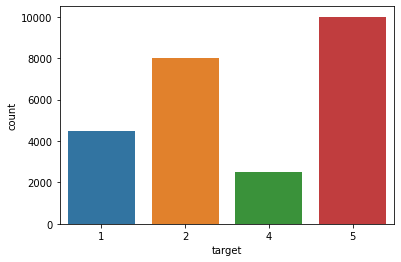

In [14]:
sns.countplot(data=df_train,x='target')

- target = 1,2,4,5 
- 1->0 | 2->1 | 4->2 | 5->3 변경

In [15]:
df_train['target'] = df_train['target'].map({1:0,2:1,4:2,5:3})
target = df_train['target']
target

0        1
1        0
2        1
3        1
4        3
        ..
24995    3
24996    1
24997    2
24998    1
24999    3
Name: target, Length: 25000, dtype: int64

- 리뷰의 길이 히스토그램으로 확인 
- 최대 리뷰 길이 140

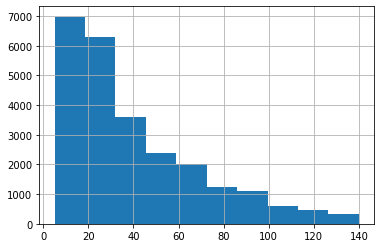

In [16]:
df_train['reviews'].str.len().hist()

## 텍스트 정제

In [17]:
!pip install emoji==0.6.0
!pip install soynlp==0.0.493

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 3.0 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49734 sha256=56802c81a714a07e2f9a59f5a033d0fe45c42e8413e8ea541801fe121a62fb2e
  Stored in directory: /root/.cache/pip/wheels/4e/bf/6b/2e22b3708d14bf6384f862db539b044d6931bd6b14ad3c9adc
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 4.7 MB/s 


In [18]:
import re # 정규식으로 전처리 
import emoji # 이모티콘 제거를 위해 이모티콘 사용 모듈 임포트 
from soynlp.normalizer import repeat_normalize 

- 텍스트 정제

- 코드 참고: https://github.com/Beomi/KcELECTRA

In [19]:
emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^.,?!/@$%~#·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')


In [20]:
# 클린 적용 함수  
def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [21]:
df_train['reviews'] = df_train['reviews'].apply(clean)
df_test['reviews'] = df_test['reviews'].apply(clean)


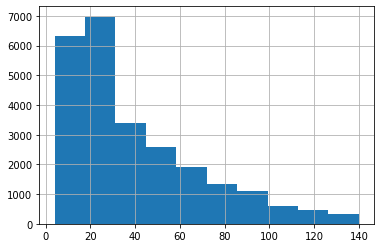

In [22]:
df_train['reviews'].str.len().hist() # 문자열 길이 분포가 바뀌었다. 

- 띄어쓰기 검사
- 띄어쓰기도 문자 구분에 있어 중요한 요소 

In [23]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-2ka9su22
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-2ka9su22
     |████████████████████████████████| 671.4 MB 1.4 kB/s 
     |████████████████████████████████| 1.3 MB 7.0 MB/s 
     |████████████████████████████████| 463 kB 19.1 MB/s 
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2268638 sha256=22f0bb46cef616d71506d797d591f577fb8122f204bc6c0b089e398c7264cb87
  Stored in directory: /tmp/pip-ephem-wheel-cache-ij5402tr/wheels/9b/93/81/a2a7dc8c66ede5bf30634d20635f32b95eac7ca2ea8844058b
Successfully built pykospacing
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempti

In [24]:
from pykospacing import Spacing

- 기존 데이터 정제 후 띄어쓰기 검사 수행 

In [25]:
#spacing =Spacing() 

#for i in tqdm(range(len(df_train))):
#  df_train.loc[i,'reviews']= spacing(df_train.loc[i,'reviews'])

In [26]:
#for i in tqdm(range(len(df_test))):
#  df_test.loc[i,'reviews']= spacing(df_test.loc[i,'reviews'])

## **모델 학습 준비**


In [27]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW 
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification



In [45]:
device =torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f'현재 device 는 {device}입니다.')

현재 device 는 cpu입니다.


- accuracy 계산

In [29]:
def accuracy(true,pred):
  return sum(true==pred)/len(true)


In [30]:
def seed_everything(seed : int =22):
  import random,os
  import numpy as np
  import torch 

  random.seed(seed)
  os.environ['PYTHONHASHSEED']=str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True 

In [31]:
seed_everything(SEED)

- 데이터 셋 

In [32]:
class CustomDataset(Dataset):
  def __init__(self,dataset,tokenizer,max_len,train_mode=True):
    self.dataset = dataset
    self.max_len = max_len 
    self.train_mode = train_mode
    self.tokenizer = tokenizer 

  def __getitem__(self,idx):
    text = self.dataset.loc[idx,'reviews']
    inputs = self.tokenizer(text,
                            return_tensors='pt',
                            truncation = True,
                            max_length = self.max_len,
                            pad_to_max_length = True,
                            add_special_tokens = True)
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    if self.train_mode:
      label = self.dataset.loc[idx,'target']
      return input_ids, attention_mask,label
    return input_ids,attention_mask 

  def __len__(self):
    return len(self.dataset)

- earlystopping 

In [33]:
class EarlyStopping:
  # 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.n_fold}.pt') 
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

# 모델 학습 

In [34]:
from sklearn.model_selection import StratifiedKFold # KFold 교차검증 

In [35]:
skfold = StratifiedKFold(n_splits =N_FOLD,shuffle =True,random_state=SEED) # 하이퍼 파라미터처음에 저장 
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)


In [36]:
def train(model,dataloader,optimizer,loss_fn,scheduler=None):
  """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
  model.train() 
  train_avg_loss = 0  ## 에폭별 배치단위 평균 훈련 오차
  train_total_batch = len(dataloader)  ## 배치 크기

  for input_ids,attention_masks, y in tqdm_notebook(dataloader): ## 미니 배치 단위로 꺼내오기 
    input_ids =input_ids.to(device)
    attention_masks = attention_masks.to(device)
    y = y.to(device)

    optimizer.zero_grad() # 그래디언트 초기화 
    yhat = model(input_ids,attention_masks)[0] # yhat 구하기 
    loss = loss_fn(yhat,y).to(device) # train loss 계산 
    loss.backward() # 미분 
    optimizer.step() # 업데이트 
    train_avg_loss += (loss.item()/train_total_batch) # 각 배치마다 훈련 오차 누적 

    # 배치마다 학습률 조절 

    if scheduler is not None :
      scheduler.step()

  return model, train_avg_loss

- 평균 평가 오차와 평가 정확도 계산 

In [37]:
def evaluate(model,dataloader,loss_fn):
  """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
  valid_avg_acc, valid_avg_loss = 0,0 

  model.eval()
  with torch.no_grad():
    for input_ids, attention_masks, y in tqdm_notebook(dataloader):
      input_ids = input_ids.to(device)
      attention_masks = attention_masks.to(device)
      y = y.to(device)

      yhat = model(input_ids,attention_masks)[0]
      loss = loss_fn(yhat,y) # valid loss 
      acc = accuracy(y.cpu().data.numpy(),yhat.cpu().data.numpy().argmax(-1))
      valid_avg_acc += (acc * len(y) / len(dataloader.dataset))
      valid_avg_loss += loss.item() / len(dataloader)
  return valid_avg_loss, valid_avg_acc

- kfold training

In [38]:
def kfold_training(data,target,skfold,model_type,loss_fn):
  seed_everything(SEED) # 시드 고정 
  model_avg_acc = []   # fold마다 정확도 저장 
  model_avg_loss = []  # fold마다 손실도 저장 
  model_epoch_train_loss = [[]for _ in range(N_FOLD)] # Fold 마다 train의 한 epoch당 valid의 배치 평균 손실 
  model_epoch_valid_loss = [[]for _ in range(N_FOLD)] # Fold 마다 valid의 한 epoch당 valid의 배치 평균 손실 
  
  # model and tokenizer 

  model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME[model_type],num_labels=NUM_CLASSES).to(device)
  tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[model_type])
  default_weight_path= f'./Data/{model_type}_default_weight.pt'
  torch.save(model.state_dict(),default_weight_path)

  for i,(train_idx,valid_idx) in enumerate(skfold.split(data,target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1}/{N_FOLD}]Fold Training...')

    train_data = data.iloc[train_idx].reset_index().drop('index',axis=1)
    valid_data = data.iloc[valid_idx].reset_index().drop('index',axis=1)

    ## 사전학습된 가중치를 불러온다
    model.load_state_dict(torch.load(default_weight_path, map_location=device)) 
            
    ## Dataset, Dataloader
    train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN, train_mode=True)
    valid_dataset = CustomDataset(valid_data, tokenizer, MAX_LEN, train_mode=True)
         
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## early stopping
    early_stopping = EarlyStopping(patience=1,
                                  verbose=False,
                                  path=SAVE_PATH,
                                  model_name=model_type,
                                  n_fold=i+1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

    ## optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)  ## transformer의 AdamW, 옵티마이저에 최적화할 파라미터와 학습률 전달
                              
    ## scheduler  
    t_total = len(train_dataloader) * EPOCHS  ## The total number of training steps
    warmup_step = int(t_total * 0.1)  ## The number of steps for the warmup phase
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
        
    ## fold 마다 모델 학습
    for epoch in range(EPOCHS):  
        model, train_avg_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)   
        valid_avg_loss, valid_avg_acc = evaluate(model, valid_dataloader, loss_fn)  
        model_epoch_train_loss[i].append(train_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        model_epoch_valid_loss[i].append(valid_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 1 == 0 or epoch == EPOCHS - 1: 
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
                
        ## epoch 마다 early stopping 실행
            early_stopping(model, valid_avg_loss, valid_avg_acc) 
            if early_stopping.early_stop: 
              if epoch % 1 != 0 and epoch != EPOCHS - 1:
                  print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
              print('Early stopping!')
              break 

    model_avg_acc.append(early_stopping.val_acc)  ## fold 마다 loss가 가장 작은 모델의 정확도
    model_avg_loss.append(early_stopping.val_loss_min)  ## fold 마다 loss가 가장 작은 모델의 손실
        
    ## fold 마다 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
        
  ## 마지막으로 fold 마다 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
  print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(model_avg_acc):.4f}')  
  print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(model_avg_loss):.4f}')

  return model, model_epoch_train_loss, model_epoch_valid_loss, model_avg_acc, model_avg_loss    


In [39]:
create_folder('./Data')

In [46]:
eletra_model, _, _, _, _ = kfold_training(df_train, target, skfold, 'electra', loss_fn)

Some weights of the model checkpoint at kykim/electra-kor-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kykim/electra-kor-base and are newly initialized: ['classifier.out_proj.weight', 'clas

[1/5]Fold Training...


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
funnel_model, _, _, _, _ = kfold_training(df, target, skfold, 'funnel', loss_fn)

## 테스트 예측

In [ ]:
def predict(model_type, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME[model_type], num_labels=NUM_CLASSES).to(device)
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) 

    for weight in tqdm(weight_path_list):
        if model_type not in weight:
            continue

        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for input_ids, attention_masks in dataloader:
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                
                outputs = model(input_ids, attention_masks)[0]
                outputs = outputs.cpu().numpy()

                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD)  
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률
    return test_preds ## 라벨

- 앙상블을 이용한 기법

In [ ]:
electra_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME['electra'])  
funnel_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME['funnel'])  

In [ ]:
test_dataset = CustomDataset(df_test, electra_tokenizer, MAX_LEN, train_mode=False)  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
test_dataset2 = CustomDataset(df_test, funnel_tokenizer, MAX_LEN, train_mode=False)  
test_dataloader2 = DataLoader(test_dataset2, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
preds1 = predict('electra', test_dataloader, SAVE_PATH, is_prob=True)
preds2 = predict('funnel', test_dataloader2, SAVE_PATH, is_prob=True)

In [ ]:
preds = preds1 + preds2
_, preds = torch.max(torch.tensor(preds), dim=1) ## 최대값과 인덱스